<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Look-into-Cross-sectional-cohort-results" data-toc-modified-id="Look-into-Cross-sectional-cohort-results-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Look into Cross-sectional cohort results</a></span></li><li><span><a href="#Look-into-just-the-Dan-et-al-dataset" data-toc-modified-id="Look-into-just-the-Dan-et-al-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Look into just the Dan et al dataset</a></span></li></ul></div>

In [1]:
# This block is just for importing the necessary libraries.  
import os
from collections import defaultdict
# Numerical libraries
import pandas as pd
import numpy as np
import biom
import arviz as az
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr
from gneiss.balances import sparse_balance_basis
# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib_venn import venn2, venn3
# custom utility and plotting functions
from util import (extract_differentials, select_features, 
                  get_genomic_data, collapse_transcripts, 
                  aggregate_pathways,
                  ranking, btest, log_pvalue, read_kegg_dict,
                  ilr_transform_differentials,
                  rename_clades, create_projection,
                  match_all_differentials)
from plot import (rankplot, networkplot, vectorplot)
import random

# directory paths
amp_directory = '../sfari/data/sra/Combined'
wgs_directory = '../sfari/data/sra_shotgun/Combined'
rna_directory = '../sfari/data/recount3'
kang_directory = '../sfari/data/sra/Kang2017'
sepp_directory = '../sfari/data/sra/Kang2017/deblur/sepp'
results_dir = '../results'
kegg_dir = f'{results_dir}/kegg'
hsa_dir = f'{results_dir}/hsa_kegg'
np.random.seed(0)
random.seed(0)
%matplotlib inline

# Look into Cross-sectional cohort results

In [2]:
# load 16S, whole genome shotgun and RNAseq data
posterior_name = 'age_sex_matched_posterior'
amp_fname = f'{kang_directory}/week0_ogu/differentials-v8.nc'
wgs_fname = f'{wgs_directory}/{posterior_name}/ogus_differentials-v5.nc'
amp_diffs = extract_differentials(amp_fname)
wgs_diffs = extract_differentials(wgs_fname)


# Compute statistical tests for each data layer
# Here, we will only focus on the top 10% of the features
amp_stats = ranking(amp_diffs, reference_percentile=90)
wgs_stats = ranking(wgs_diffs, reference_percentile=90)

Overlap in all of the taxa

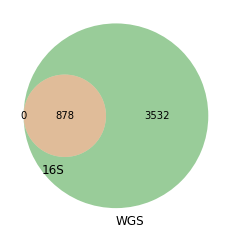

In [3]:
# Venn diagram to visualize overlap
venn2([set(amp_diffs.index), 
       set(wgs_diffs.index)], 
      set_labels=['16S', 'WGS'])

In [4]:
common_taxa = list(set(amp_diffs.index) & set(wgs_diffs.index))

In [5]:
amp_diffs_c = amp_diffs.loc[common_taxa]
wgs_diffs_c = wgs_diffs.loc[common_taxa]

amp_stats_c = amp_stats.loc[common_taxa]
wgs_stats_c = wgs_stats.loc[common_taxa]

Average log-fold changes

In [6]:
amp_idx = np.logical_and(amp_stats_c['pvalue'] < 0.001, amp_stats_c['tstat'] > 0)
wgs_idx = np.logical_and(wgs_stats_c['pvalue'] < 0.001, wgs_stats_c['tstat'] > 0)

Text(0, 0.5, '% Common taxa')

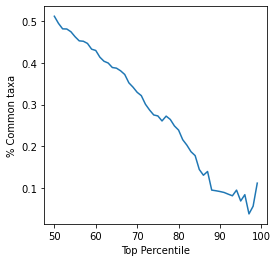

In [7]:
def overlap_f(x, y, q=100):
    x_thres = np.percentile(x.values, q)
    y_thres = np.percentile(y.values, q)
    x_set = set(x.loc[x > x_thres].index)
    y_set = set(y.loc[y > y_thres].index)
    # print(x_thres, y_thres, len(x_set & y_set), len(x_set), len(y_set))
    return len(x_set & y_set) / len(x_set)

spacing = np.linspace(50, 99, 50)
overlaps = [overlap_f(amp_stats_c['mean'], wgs_stats_c['mean'], q) for q in spacing]

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(spacing, overlaps)
ax.set_xlabel('Top Percentile')
ax.set_ylabel('% Common taxa')

In [8]:
int_amp = list(set(amp_stats_c.loc[amp_idx].index) & set(wgs_stats_c.loc[wgs_idx].index))

Overlap in significant taxa

Text(0.5, 1.0, 'Overlap in significant taxa')

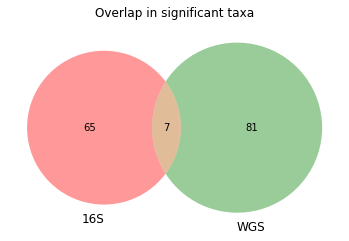

In [9]:
# Venn diagram to visualize overlap
venn2([set(amp_stats_c.loc[amp_idx].index), 
       set(wgs_stats_c.loc[wgs_idx].index)], 
      set_labels=['16S', 'WGS'])
plt.title('Overlap in significant taxa')

In [10]:
amp_thres = amp_stats_c.loc[amp_idx, 'mean'].min()
wgs_thres = wgs_stats_c.loc[wgs_idx, 'mean'].min()
amp_max = amp_stats_c.loc[amp_idx, 'mean'].max()
wgs_max = wgs_stats_c.loc[wgs_idx, 'mean'].max()

In [11]:
amp_thres, wgs_thres, amp_max, wgs_max

(1.379696998953192, 0.7529781638539339, 5.497339106453191, 2.2723983848539335)

In [12]:
amp_stats_c['mean'].max()

5.497339106453191

Text(0.5, 1.0, 'Cross-sectional')

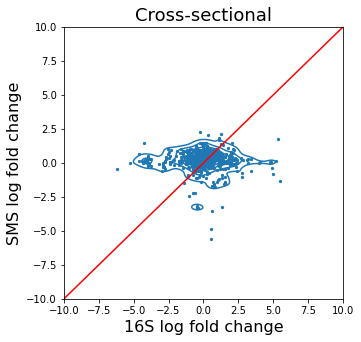

In [13]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(5, 5))
common_data = pd.DataFrame({
    'WGS' : wgs_stats_c['mean'],
    '16S' : amp_stats_c['mean']
})
sns.kdeplot(data=common_data, x="16S", y="WGS", ax=ax)
plt.scatter(common_data['16S'], common_data['WGS'], s=5)
plt.plot(np.linspace(-10, 10), np.linspace(-10, 10), 'r')
ax.set_xlabel('16S log fold change', fontsize=16)
ax.set_ylabel('SMS log fold change', fontsize=16)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_title('Cross-sectional', fontsize=18)

<ErrorbarContainer object of 3 artists>

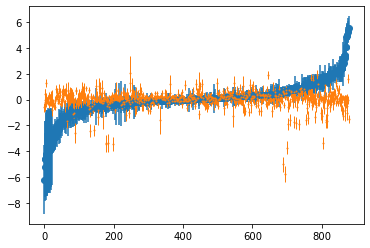

In [14]:
amp_diffs_common = amp_diffs.loc[common_taxa]
wgs_diffs_common = wgs_diffs.loc[common_taxa]

idx = amp_diffs_common.mean(axis=1).sort_values().index
amp_diffs_common = amp_diffs_common.loc[idx]
wgs_diffs_common = wgs_diffs_common.loc[idx]

amp_diff_mean = amp_diffs_common.mean(axis=1)
amp_diff_std = amp_diffs_common.std(axis=1)

wgs_diff_mean = wgs_diffs_common.mean(axis=1)
wgs_diff_std = wgs_diffs_common.std(axis=1)

x = np.arange(len(amp_diffs))

plt.errorbar(x, amp_diff_mean, yerr=amp_diff_std, fmt='o')
plt.errorbar(x, wgs_diff_mean, yerr=wgs_diff_std, fmt='o', markersize=1, linewidth=1)

Correlations on the average log fold changes

In [15]:
pearsonr(amp_stats_c['mean'], wgs_stats_c['mean'])

(-0.023650932180654994, 0.4839886177895695)

In [16]:
spearmanr(amp_stats_c['mean'], wgs_stats_c['mean'])

SpearmanrResult(correlation=0.020878690196634166, pvalue=0.5366782983511611)

Correlations on all of the posterior samples

In [17]:
pearsonr(amp_diffs_c.values.ravel(), wgs_diffs_c.values.ravel())

(-0.018746666702043422, 1.1139513000839465e-28)

In [18]:
spearmanr(amp_diffs_c.values.ravel(), wgs_diffs_c.values.ravel())

SpearmanrResult(correlation=0.019785980112571804, pvalue=9.301551864160559e-32)

# Look into just the Dan et al dataset

In [19]:
data_dir = '../data/amp_wgs_comparison'
inf_amp = az.from_netcdf(f'{data_dir}/differentials_amp.nc')
inf_wgs = az.from_netcdf(f'{data_dir}/differentials_wgs.nc')

amp_diff = inf_amp['posterior']['diff'].to_dataframe()
wgs_diff = inf_wgs['posterior']['diff'].to_dataframe()

In [20]:
amp_diff_df = pd.pivot(data=amp_diff.reset_index(), index='features', columns=('chain', 'draw'))
wgs_diff_df = pd.pivot(data=wgs_diff.reset_index(), index='features', columns=('chain', 'draw'))

amp_alr = amp_diff_df - amp_diff_df.iloc[0] 
wgs_alr = wgs_diff_df - wgs_diff_df.iloc[0] 

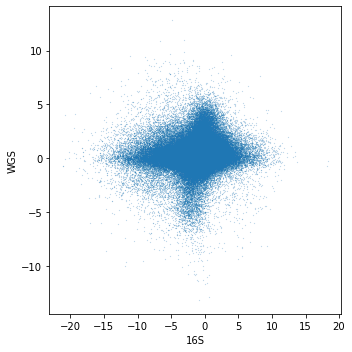

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(amp_alr.values.ravel(), wgs_alr.values.ravel(), s=.01)
ax.set_xlabel('16S')
ax.set_ylabel('WGS')
plt.tight_layout()

In [22]:
amp_mean = amp_diff.reset_index().groupby('features').mean()['diff']
wgs_mean = wgs_diff.reset_index().groupby('features').mean()['diff']

/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/mnt/home/jmorton/miniconda3/envs/qiime2-2021.4/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


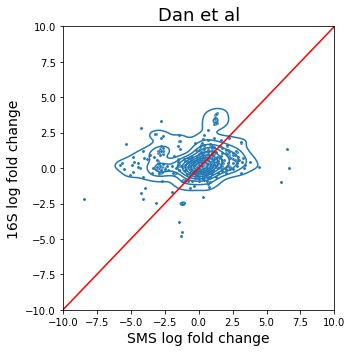

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
#ax.scatter(amp_mean.values, wgs_mean.values, s=3)
sns.kdeplot(amp_mean.values, wgs_mean.values)
sns.scatterplot(amp_mean.values, wgs_mean.values, s=10)
ax.plot(np.linspace(-10, 10), np.linspace(-10, 10), 'r')
ax.set_xlabel('SMS log fold change', fontsize=14)
ax.set_ylabel('16S log fold change', fontsize=14)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_title('Dan et al', fontsize=18)
plt.tight_layout()

In [30]:
amp_diff = extract_differentials(f'{data_dir}/differentials_amp.nc')
wgs_diff = extract_differentials(f'{data_dir}/differentials_wgs.nc')

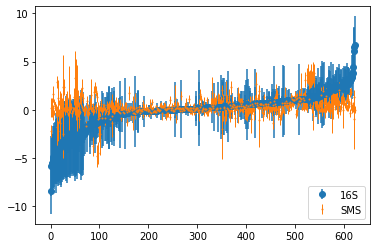

In [39]:
common_taxa = list(set(amp_diff.index) & set(wgs_diff.index))

amp_diffs_common = amp_diff.loc[common_taxa]
wgs_diffs_common = wgs_diff.loc[common_taxa]

idx = amp_diffs_common.mean(axis=1).sort_values().index
amp_diffs_common = amp_diffs_common.loc[idx]
wgs_diffs_common = wgs_diffs_common.loc[idx]

amp_diff_mean = amp_diffs_common.mean(axis=1)
amp_diff_std = amp_diffs_common.std(axis=1)

wgs_diff_mean = wgs_diffs_common.mean(axis=1)
wgs_diff_std = wgs_diffs_common.std(axis=1)

x = np.arange(len(amp_diff))

plt.errorbar(x, amp_diff_mean, yerr=amp_diff_std, fmt='o', label='16S')
plt.errorbar(x, wgs_diff_mean, yerr=wgs_diff_std, fmt='o', markersize=1, linewidth=1, label='SMS')
plt.legend(loc=4)